# Supplementary: Counts of differentially expressed genes per examined tissue

This notebook aggregates the results from the differential gene expression (**see** [figure1.ipynb](figure1.ipynb)), and more specifically the `limma::topTable()` output dataframes across all tissues in the GTEX cohort and generates summary statistics for the number of genes found to be statistically up or downregulated between male and female subjects.

 ---
 
 **Running this notebook**:
 
A few steps are needed before you can run this document on your own. The GitHub repository (https://github.com/TheJacksonLaboratory/sbas) of the project contains detailed instructions for setting up the environment in the **`dependencies/README.md`** document. Before starting with the analysis, make sure you have first completed the dependencies set up by following the instructions described there. If you have not done this already, you will need to close and restart this notebook before running it.

All paths defined in this Notebook are relative to the parent directory (repository). 

 ---


# Loading dependencies

In [1]:
library(dplyr)
library(reshape)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”


## To get the last column fields of the GTF file to annotate the gene ids

The `limma::topTable()` dataframes encode the feature information (genes) as rownames of the dataframe. The values are Ensembl Gene IDs. To map the Gene ids to Gene symbold we will use a the fields in the last column of the relevant GTF file. 

Note: If you are using GENCODE to retrieve the GTF file, use the relevant field name for the gene ID:

| Source | Gene Identifier Name |
|---:|:---|
| GENCODE|`Geneid`|
| Ensembl|`gene_id`|


- Here are some quick links to retrieve the GTF file, either from Ensembl or GENCODE:

```bash
wget ftp://ftp.ensembl.org/pub/release-100/gtf/homo_sapiens/Homo_sapiens.GRCh38.100.chr_patch_hapl_scaff.gtf.gz -P ../data
wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_30/gencode.v30.chr_patch_hapl_scaff.annotation.gtf.gz -P ../data
```

- To parse the GTF file and retrieve the fields associated with the Gene IDs, Gene Symbols etc you could use the following bash snippet, depending on the source of your GTF (Ensembl, GENCODE) as these two files slightly differ.

```bash
# found here: https://www.biostars.org/p/140471/
cd sbas/data

zcat gencode.v30.annotation.gtf.gz | awk 'BEGIN{FS="\t"}{split($9,a,";"); if($3~"gene") print a[1]"\t"a[3]"\t"$1":"$4"-"$5"\t"a[2]"\t"$7}' |sed 's/gene_id "//' | sed 's/gene_id "//' | sed 's/gene_type "//'| sed 's/gene_name "//' | sed 's/"//g' | awk 'BEGIN{FS="\t"}{split($3,a,"[:-]"); print $1"\t"$2"\t"a[1]"\t"a[2]"\t"a[3]"\t"$4"\t"$5"\t"a[3]-a[2];}' | sed "1i\Geneid\tGeneSymbol\tChromosome\tStart\tEnd\tClass\tStrand\tLength" > gencode.v30.annotation.gtf.gz.txt

zcat Homo_sapiens.GRCh38.100.chr_patch_hapl_scaff.gtf.gz | awk 'BEGIN{FS="\t"}{split($9,a,";"); if($3~"gene") print a[1]"\t"a[3]"\t"$1":"$4"-"$5"\t"a[5]"\t"$7}' | sed 's/gene_id "//' | sed 's/gene_id "//' | sed 's/gene_biotype "//'| sed 's/gene_name "//' | sed 's/gene_biotype "//' | sed 's/"//g' | sed 's/ //g' | sed '1igene_id\tGeneSymbol\tChromosome\tClass\tStrand' > Homo_sapiens.GRCh38.100.chr_patch_hapl_scaff.gtf.gz.txt 
```

## Preview the GTF tables with the gene attributes

To make sure the snippets above have worked as expected, take a look in the tables with `head()`:

In [2]:
ensembl_path <- "Homo_sapiens.GRCh38.100.chr_patch_hapl_scaff.gtf.gz.txt"
gencode_path <- "gencode.v30.chr_patch_hapl_scaff.annotation.gtf.gz.txt"
gtf_ensembl <- read.table(paste0("../data/", ensembl_path), header = TRUE)
gtf_gencode <- read.table(paste0("../data/", gencode_path), header = TRUE)

head(gtf_ensembl,2)
head(gtf_gencode,2)

,gene_id,GeneSymbol,Chromosome,Class,Strand
,<fct>,<fct>,<fct>,<fct>,<fct>
1,ENSG00000223972,DDX11L1,1:11869-14409,transcribed_unprocessed_pseudogene,+
2,ENSG00000227232,WASH7P,1:14404-29570,unprocessed_pseudogene,-


,Geneid,GeneSymbol,Chromosome,Start,End,Class,Strand,Length
,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>
1,ENSG00000223972.5,DDX11L1,chr1,11869,14409,transcribed_unprocessed_pseudogene,+,2540
2,ENSG00000227232.5,WASH7P,chr1,14404,29570,unprocessed_pseudogene,-,15166


# Create a list of named dataframes with the Differential Gene Expression `limma::topTable()`s

We will iterate over the list of named dataframes to collect summary statistics. More specifically, retrieve the count of:
- upregulated
- downregulated
- non significant

genes for the contrast males-females per tissue.

In [3]:
dge_tables_filepaths <- list.files("../data/dge", pattern = "*DGE.csv", full.names = TRUE)
dge_tables_filenames <- list.files("../data/dge", pattern = "*DGE.csv", full.names = FALSE)

In [4]:
all_topTables <- lapply(dge_tables_filepaths,read.csv)
names(all_topTables) <- gsub("_DGE.csv","", dge_tables_filenames, fixed = TRUE)

The list named `all_topTables` is the object that holds all the topTable dataframes from each tissue comparison:

In [5]:
length(all_topTables)

[1] 46

In [6]:
summary(all_topTables)

                                     Length Class      Mode
Adipose-Subcutaneous                 6      data.frame list
Adipose-Visceral(Omentum)            6      data.frame list
AdrenalGland                         6      data.frame list
Artery-Aorta                         6      data.frame list
Artery-Coronary                      6      data.frame list
Artery-Tibial                        6      data.frame list
Bladder                              6      data.frame list
Brain-Amygdala                       6      data.frame list
Brain-Anteriorcingulatecortex(BA24)  6      data.frame list
Brain-Caudate(basalganglia)          6      data.frame list
Brain-CerebellarHemisphere           6      data.frame list
Brain-Cerebellum                     6      data.frame list
Brain-Cortex                         6      data.frame list
Brain-FrontalCortex(BA9)             6      data.frame list
Brain-Hippocampus                    6      data.frame list
Brain-Hypothalamus                   6  

# Trim gene versions from gene names to match Gene Identifiers from GTF (GENCODE, Ensembl)
Remove characters after `.` in the Gene Identifier column, since as long as the gene version information is present we will not be able to perform a join, to annotate the toptable dataframes with the GTF gene attrubutes.

In [7]:
GTF_SOURCE <- "ensembl"      # c("gencode", "ensembl")
GENE_ID    <- "gene_id"      # c("Geneid" , "gene_id")

if (GTF_SOURCE == "gencode") { GTF <- gtf_gencode}
if (GTF_SOURCE == "ensembl") { GTF <- gtf_ensembl}

GTF[[GENE_ID]]       <- gsub("\\..*","", GTF[[GENE_ID]])

# Example with one topTable before iterating over all tissues

In [8]:
# Example topTable and name
topTable <- all_topTables[[1]]
name     <- names( all_topTables)[1]
topTable[[GENE_ID]]  <- gsub("\\..*","", rownames(topTable))
name
head(topTable,2)
head(GTF, 2)

[1] "Adipose-Subcutaneous"

,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000129824.15,-9.668735,4.643844,-145.5404,0,0,1136.058,ENSG00000129824
ENSG00000229807.10,9.907847,1.246117,131.3680,0,0,1079.040,ENSG00000229807


,gene_id,GeneSymbol,Chromosome,Class,Strand
,<chr>,<fct>,<fct>,<fct>,<fct>
1,ENSG00000223972,DDX11L1,1:11869-14409,transcribed_unprocessed_pseudogene,+
2,ENSG00000227232,WASH7P,1:14404-29570,unprocessed_pseudogene,-


## Defining the thresholds for the double criterion filtering:

Criteria:
- Adjusted p-value < `p_value_cuttoff`
- Absolut FoldChange > `absFold_change_threshold`

----

***NOTE***

Defining higher in males or females based on the limma design matrix
As we have used 1 for encoding the females and 2 for the males, our *reference level* for the contrast in the expression between males and females is 1, the females.


From the `limma` documentation:
>The level which is chosen for the *reference level* is the level which is contrasted against. By default, this is simply the first level alphabetically. We can specify that we want group 2 to be the reference level by either using the relevel function [..]

By convention, we could say that genes with positive log fold change, are higher in males, whereas the opposite holds true for the ones that are observed to have negative log folde change. 

---

In [9]:
adj.P.Val_threshold  <- 0.5
absFoldChange_cutoff <- 1.5

Replacing potential `NA` values in the `P.Value`, `adj.P.Val` to keep the columns numeric and avoid coersion.

In [10]:
# replacing NA p-values with p-value = 1
topTable$P.Value[is.na(topTable$P.Value)]     <- 1; 
topTable$adj.P.Val[is.na(topTable$adj.P.Val)] <- 1;

In [11]:
# Add helper variable dummy `FoldChange` variable. Use 2 as base of log, because this is the default from limma
# The following statement calculates a dummy fold change (how many times higher or lower)
# The minus symbol is a convention symbol only! to express eg. a fold change of 0.25 as -4, 4 times lower
topTable$FoldChange_dummy    <-   ifelse(topTable$logFC > 0, 2 ^ topTable$logFC, -1 / (2 ^ topTable$logFC))                    

# Add helper variable `abs_logFC`.
topTable$abs_logFC <- abs(topTable$logFC)

# Add helper variable `abundance` for up, down, non_signif
topTable$abundance                                                  <- "non_signif"
topTable$abundance[(topTable$logFC >   log2(absFoldChange_cutoff)) & (topTable$adj.P.Val <= adj.P.Val_threshold )]   <- "higher"
topTable$abundance[(topTable$logFC <  -log2(absFoldChange_cutoff)) & (topTable$adj.P.Val <= adj.P.Val_threshold )]   <- "lower"

In [12]:
head(topTable)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene_id,FoldChange_dummy,abs_logFC,abundance
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
ENSG00000129824.15,-9.668735,4.6438444,-145.54037,0,0,1136.0576,ENSG00000129824,-813.9156,9.668735,lower
ENSG00000229807.10,9.907847,1.2461171,131.36798,0,0,1079.0402,ENSG00000229807,960.6365,9.907847,higher
ENSG00000067048.16,-9.698380,3.7021122,-108.38685,0,0,952.4945,ENSG00000067048,-830.8129,9.698380,lower
ENSG00000176728.7,-8.082798,-0.9202562,-105.59458,0,0,922.2647,ENSG00000176728,-271.1219,8.082798,lower
ENSG00000012817.15,-9.608969,3.4369019,-101.87186,0,0,914.3474,ENSG00000012817,-780.8863,9.608969,lower
ENSG00000198692.9,-9.013909,1.3461188,-90.30504,0,0,835.7359,ENSG00000198692,-516.9601,9.013909,lower


# Define a vector with the columns to keep in the annotated from GTF `topTable` object

In [13]:
toKeep <- c("Geneid","logFC","FoldChange_dummy", "adj.P.Val", "abundance")

In [14]:
head(topTable[ , colnames(topTable) %in% toKeep ],2)

,logFC,adj.P.Val,FoldChange_dummy,abundance
,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000129824.15,-9.668735,0,-813.9156,lower
ENSG00000229807.10,9.907847,0,960.6365,higher


In [15]:
name
dim(topTable)
dim(topTable [topTable$abundance != "non_signif",  ])
dim(topTable [ (topTable$abundance != "non_signif" )  & (topTable$adj.P.Val <= adj.P.Val_threshold ) ,  ])

[1] "Adipose-Subcutaneous"

[1] 15895    10

[1] 275  10

[1] 275  10

In [16]:
expression_abundance <- t(table(topTable$abundance))
expression_abundance

      
       higher lower non_signif
  [1,]     80   195      15620

In [17]:
expression_abundance <- t(table(topTable$abundance))
signif <- as.data.frame.matrix(expression_abundance)

In [18]:
signif

higher,lower,non_signif
<int>,<int>,<int>
80,195,15620


To avoid errors in the cases that we might have none lower or none higher, and the matrix might be missing columns we will create a template data.frame and also add the column that might be missing if lower or higher genes is equal to 0.

In [19]:
signif_template <- structure(list(higher = integer(0), 
                                   lower = integer(0), 
                                   non_signif = integer(0)), 
                              row.names = integer(0), class = "data.frame")
signif_template

higher,lower,non_signif
<int>,<int>,<int>


In the for-loop we will check if both columns `lower`, `higher` are present, if not add the column and zero count to create the expected sshape of the dataframe:

```R
signif <- as.data.frame.matrix(expression_abundance)
if(! ("higher" %in% colnames(signif))) { 
    
    signif$higher <- 0
}
if(! ("lower" %in% colnames(signif))) { 

    signif$lower <- 0
}
```

Now we can add some more summary statistics eg percentage of genes lower, higher or non-significantly different, 

In [20]:
signif$tissue <- name
signif$sum    <- signif$non_signif + signif$higher + signif$lower
toKeepInOrder <- c("tissue", "non_signif", "lower", "higher", "% lower", "% higher", "% non-signif")
signif$`% higher`     <-  round(signif$higher / signif$sum  * 100, 2)
signif$`% lower`      <-  round(signif$lower / signif$sum  * 100, 2)
signif$`% non-signif` <-  round(signif$non_signif / signif$sum  * 100, 2)
signif <- signif[, toKeepInOrder]
signif

tissue,non_signif,lower,higher,% lower,% higher,% non-signif
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
Adipose-Subcutaneous,15620,195,80,1.23,0.5,98.27


# Summary table of differentially expressed genes between male and female acrosss tissues

Above we demonstrate for one example limma `topTable`. Let's now iterate over all tissue and create an aggregated table of counts of differentially expressed or non-significantly altered between the two sexes.

In [21]:
summary_signif <-structure(list(tissue = character(0), 
                            non_signif = integer(0), 
                            lower = integer(0),
                            higher = integer(0),
                            `% lower` = numeric(0), 
                            `% higher` = numeric(0), 
                            `% non-signif` = numeric(0)), 
                       row.names = integer(0), 
                       class = "data.frame")

signif_template <- structure(list(higher = integer(0), 
                                   lower = integer(0), 
                                   non_signif = integer(0)), 
                              row.names = integer(0), class = "data.frame")

signif_per_tissue <- structure(list(logFC = numeric(0), AveExpr = numeric(0), t = numeric(0), 
                        P.Value = numeric(0), adj.P.Val = numeric(0), B = numeric(0), 
                        initial_gene_id = character(0), gene_id = character(0), abs_logFC = numeric(0), 
                        FoldChange_dummy = numeric(0), abundance = character(0), 
                        GeneSymbol = character(0), Chromosome = character(0), Class = character(0), 
                        Strand = character(0), tissue = character(0)), row.names = integer(0), class = "data.frame")


for (i in seq_along(all_topTables)){
    topTable <- all_topTables[[i]]
    name     <- names(all_topTables)[i] 
    initial_gene_id <- paste0("initial_", GENE_ID)
    topTable[[initial_gene_id]] <- rownames(topTable)
    topTable[[GENE_ID]]  <- gsub("\\..*","", rownames(topTable))
    # replacing NA p-values with p-value = 1
    topTable$P.Value[is.na(topTable$P.Value)]     <- 1; 
    topTable$adj.P.Val[is.na(topTable$adj.P.Val)] <- 1;
    topTable$abs_logFC <- abs(topTable$logFC)
    # Add helper variable dummy `FoldChange` variable. Use 2 as base of log, because this is the default from limma
    # The following statement calculates a dummy fold change (how many times higher or lower)
    # The minus symbol is a convention symbol only! to express eg. a fold change of 0.25 as -4, 4 times lower
    topTable$FoldChange_dummy    <-   ifelse(topTable$logFC > 0, 2 ^ topTable$logFC, -1 / (2 ^ topTable$logFC))                    

    # Add helper variable `abs_logFC`.
    topTable$abs_logFC <- abs(topTable$logFC)

    # Add helper variable `abundance` for up, down, non_signif
    topTable$abundance                                                  <- "non_signif"
    topTable$abundance[(topTable$logFC >   log2(absFoldChange_cutoff)) & (topTable$adj.P.Val <= adj.P.Val_threshold )]   <- "higher"
    topTable$abundance[(topTable$logFC <  -log2(absFoldChange_cutoff)) & (topTable$adj.P.Val <= adj.P.Val_threshold )]   <- "lower"
    before_gtf_merge <- dim(topTable)[1]
    topTable <- dplyr::left_join(topTable, GTF, by = GENE_ID)
    topTable_signif <- topTable[ topTable$abundance != "non_signif", ]
    topTable_signif$tissue <- name
    signif_per_tissue <- rbind(signif_per_tissue, topTable_signif )
    data.table::fwrite(file = paste0("../data/signif_", snakecase::to_snake_case(name), ".csv"), topTable_signif)
    after_gtf_merge <- dim(topTable)[1]
    message( name, ", N features before GTF merge: ",before_gtf_merge, ", after: ", after_gtf_merge)
    expression_abundance <- t(table(topTable$abundance))
    signif <- as.data.frame.matrix(expression_abundance)
    if(! ("higher" %in% colnames(signif))) {
        signif$higher <- 0
    }
    if(! ("lower" %in% colnames(signif))) {
        signif$lower <- 0
    }
    signif$tissue <- name
    signif$sum    <-   signif$non_signif + signif$higher + signif$lower
    toKeepInOrder <- c("tissue", "non_signif", "lower", "higher", "% lower", "% higher", "% non-signif")
    signif$`% higher`     <-  round(signif$higher / signif$sum  * 100, 2)
    signif$`% lower`      <-  round(signif$lower / signif$sum  * 100, 2)
    signif$`% non-signif` <-  round(signif$non_signif / signif$sum  * 100, 2)
    signif <- signif[, toKeepInOrder]
    summary_signif <- rbind(summary_signif, signif)   
}

summary_signif <- summary_signif[order(summary_signif$`% non-signif`), ]
head(summary_signif)
head(signif_per_tissue)

Adipose-Subcutaneous, N features before GTF merge: 15895, after: 15895

Adipose-Visceral(Omentum), N features before GTF merge: 15895, after: 15895

AdrenalGland, N features before GTF merge: 15895, after: 15895

Artery-Aorta, N features before GTF merge: 15895, after: 15895

Artery-Coronary, N features before GTF merge: 15895, after: 15895

Artery-Tibial, N features before GTF merge: 15895, after: 15895

Bladder, N features before GTF merge: 15895, after: 15895

Brain-Amygdala, N features before GTF merge: 15895, after: 15895

Brain-Anteriorcingulatecortex(BA24), N features before GTF merge: 15895, after: 15895

Brain-Caudate(basalganglia), N features before GTF merge: 15895, after: 15895

Brain-CerebellarHemisphere, N features before GTF merge: 15895, after: 15895

Brain-Cerebellum, N features before GTF merge: 15895, after: 15895

Brain-Cortex, N features before GTF merge: 15895, after: 15895

Brain-FrontalCortex(BA9), N features before GTF merge: 15895, after: 15895

Brain-Hippocam

,tissue,non_signif,lower,higher,% lower,% higher,% non-signif
,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
21,Breast-MammaryTissue,14082,682,1131,4.29,7.12,88.59
35,MinorSalivaryGland,15614,59,222,0.37,1.40,98.23
1,Adipose-Subcutaneous,15620,195,80,1.23,0.50,98.27
39,Pituitary,15676,193,26,1.21,0.16,98.62
14,Brain-FrontalCortex(BA9),15702,21,172,0.13,1.08,98.79
33,Liver,15736,107,52,0.67,0.33,99.00


,logFC,AveExpr,t,P.Value,adj.P.Val,B,initial_gene_id,gene_id,abs_logFC,FoldChange_dummy,abundance,GeneSymbol,Chromosome,Class,Strand,tissue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>,<fct>,<chr>
1,-9.668735,4.6438444,-145.54037,0,0,1136.0576,ENSG00000129824.15,ENSG00000129824,9.668735,-813.9156,lower,RPS4Y1,Y:2841602-2932000,protein_coding,+,Adipose-Subcutaneous
2,9.907847,1.2461171,131.36798,0,0,1079.0402,ENSG00000229807.10,ENSG00000229807,9.907847,960.6365,higher,XIST,X:73820649-73852723,lncRNA,-,Adipose-Subcutaneous
3,-9.698380,3.7021122,-108.38685,0,0,952.4945,ENSG00000067048.16,ENSG00000067048,9.698380,-830.8129,lower,DDX3Y,Y:12904108-12920478,protein_coding,+,Adipose-Subcutaneous
4,-8.082798,-0.9202562,-105.59458,0,0,922.2647,ENSG00000176728.7,ENSG00000176728,8.082798,-271.1219,lower,TTTY14,Y:18772706-19077563,lncRNA,-,Adipose-Subcutaneous
5,-9.608969,3.4369019,-101.87186,0,0,914.3474,ENSG00000012817.15,ENSG00000012817,9.608969,-780.8863,lower,KDM5D,Y:19703865-19744939,protein_coding,-,Adipose-Subcutaneous
6,-9.013909,1.3461188,-90.30504,0,0,835.7359,ENSG00000198692.9,ENSG00000198692,9.013909,-516.9601,lower,EIF1AY,Y:20575776-20593154,protein_coding,+,Adipose-Subcutaneous


# Defining higher in males or females based on the limma design matrix
As we have used 1 for encoding the males and 2 for the females, our *reference level* for the contrast in the expression between males and females is 1, the males.


From the `limma` documentation:
>The level which is chosen for the *reference level* is the level which is contrasted against. By default, this is simply the first level alphabetically. We can specify that we want group 2 to be the reference level by either using the relevel function [..]

By convention, we could say that genes with positive log fold change, are higher in females, whereas the opposite holds true for the ones that are observed to have negative log folde change. 

In [22]:
summary_signif$`higher in males`   <- summary_signif$lower
summary_signif$`higher in females` <- summary_signif$higher
head(summary_signif[summary_signif$tissue == "Adipose-Subcutaneous", ])

,tissue,non_signif,lower,higher,% lower,% higher,% non-signif,higher in males,higher in females
,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,Adipose-Subcutaneous,15620,195,80,1.23,0.5,98.27,195,80


# Preparing the summary table for plotting

We will need to aggregate the number of genes in one column in order to be able to plot, and also convert the `Tissue` column to a factor. We will use the `reshape` R package to *melt* the dataframe from a wide to a long version, as described above:

In [23]:
toPlot <- summary_signif[, c( "tissue", "higher in males", "higher in females")]
toPlot <- reshape::melt(toPlot, id=c("tissue"))
toPlot$tissue <- as.factor(toPlot$tissue)
colnames(toPlot) <- c("Tissue", "Sex Bias", "Number of Genes")
head(toPlot[toPlot$Tissue == "Adipose-Subcutaneous", ])

,Tissue,Sex Bias,Number of Genes
,<fct>,<fct>,<dbl>
3,Adipose-Subcutaneous,higher in males,195
49,Adipose-Subcutaneous,higher in females,80


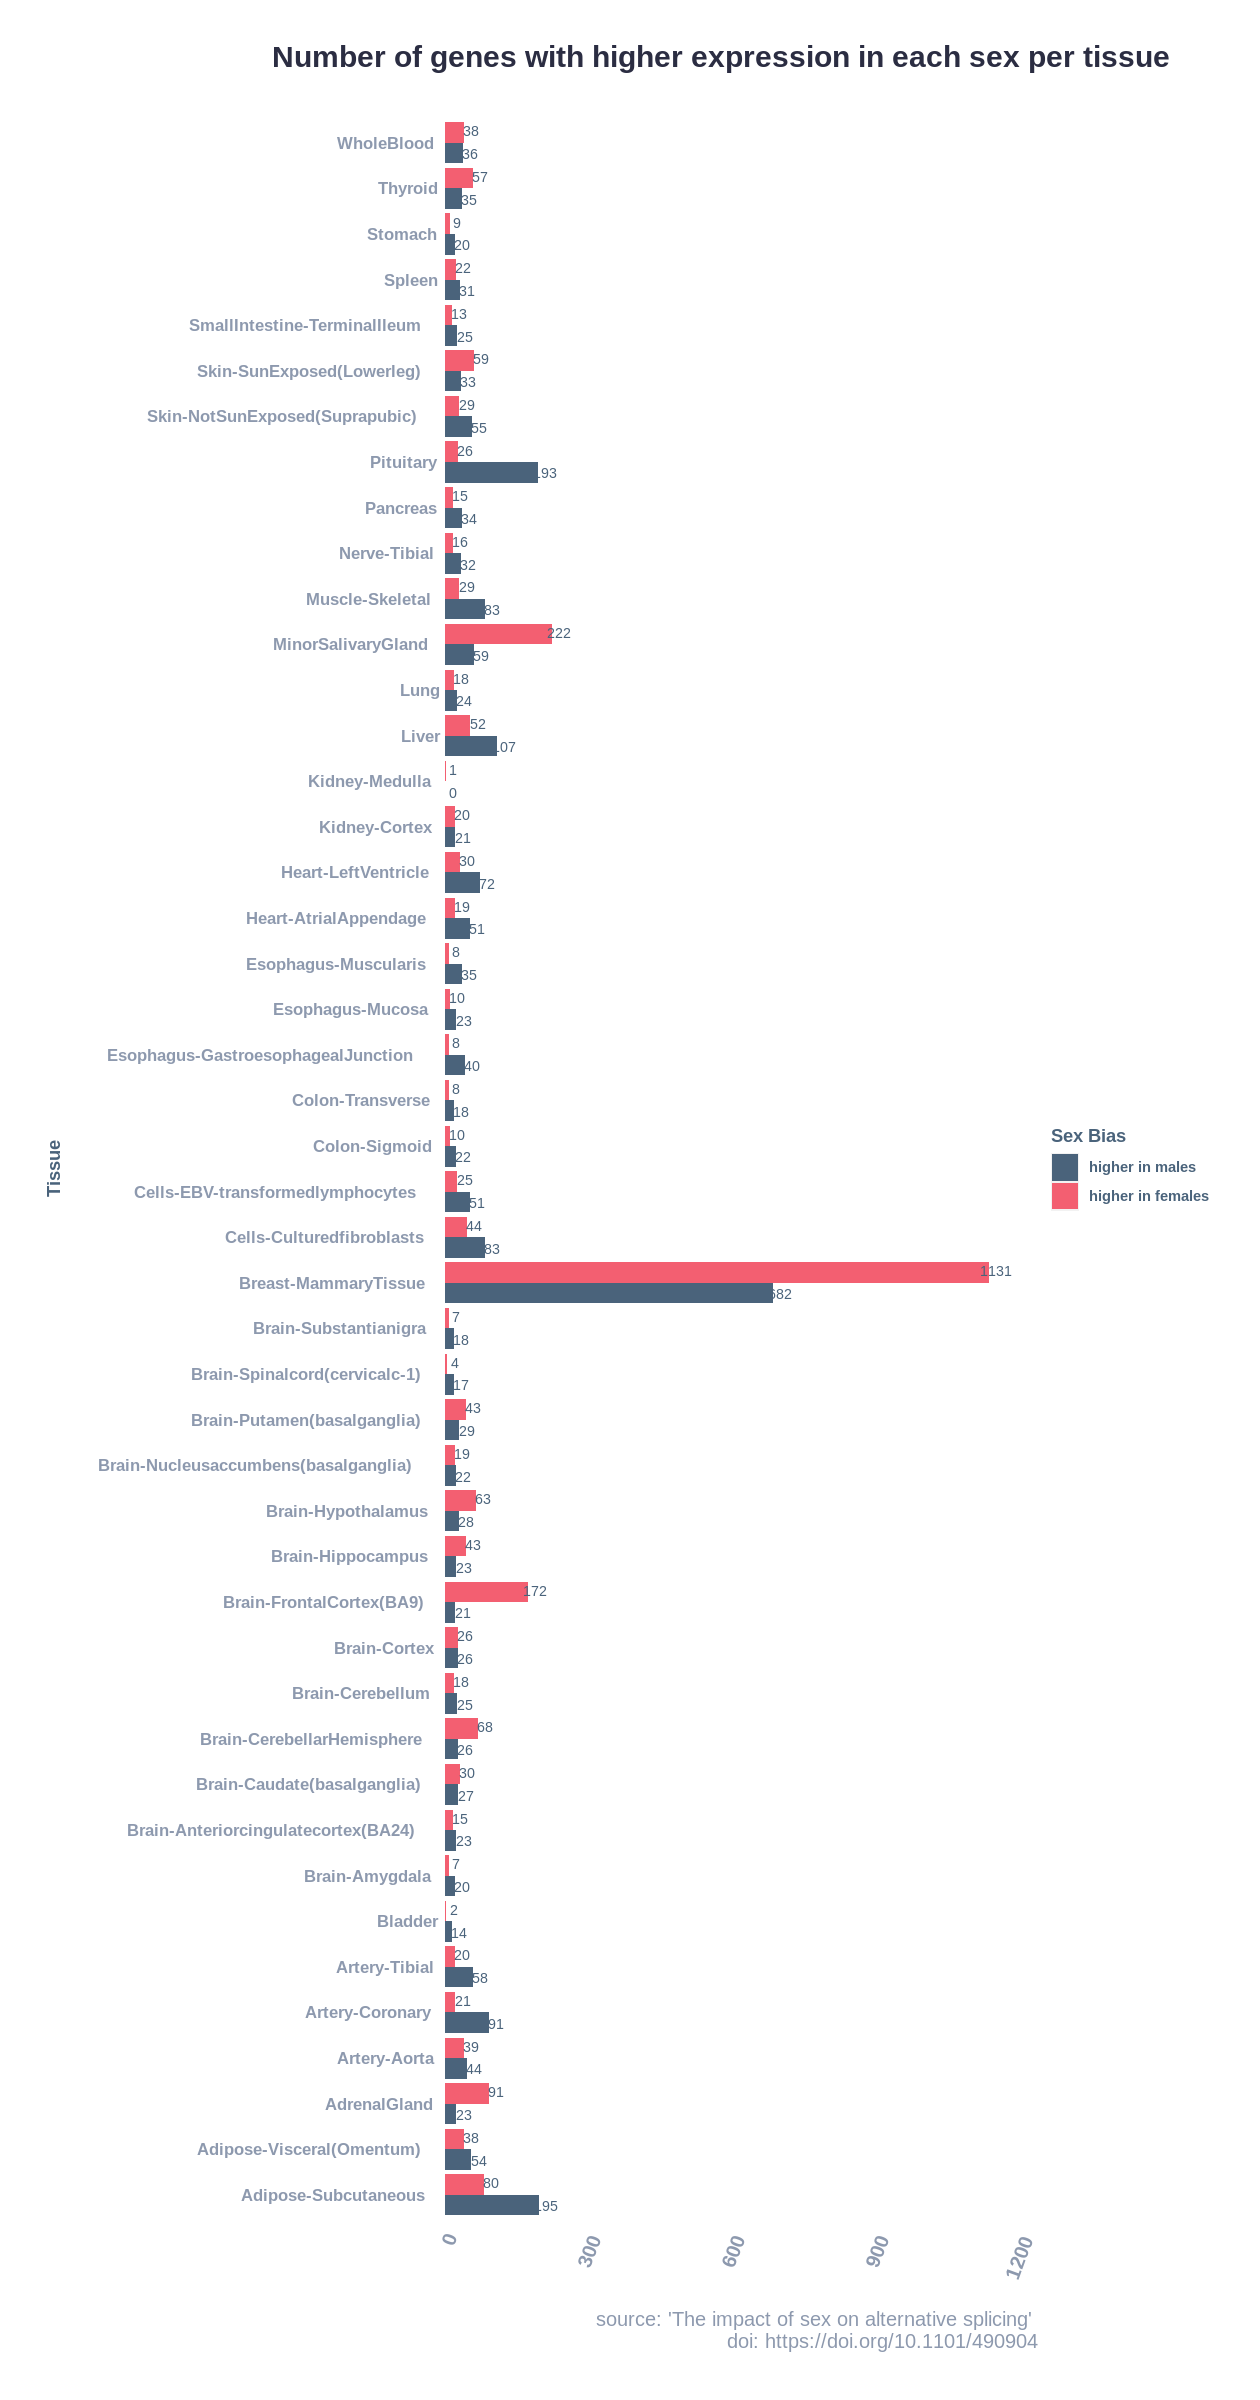

In [24]:
options(repr.plot.width=10.5, repr.plot.height=20)

ggplot(toPlot, aes(x = Tissue, y = `Number of Genes`, fill = `Sex Bias`)) + 
  geom_bar(stat="identity", position = "dodge") + 
  scale_fill_manual (values = c( "higher in males" = "#4A637B" , "higher in females" = "#f35f71")) + 
  
  theme(text              = element_text(color = "#4A637B", face = "bold", family = 'Helvetica')
        ,plot.caption     = element_text(size =  12, color = "#8d99ae", face = "plain", hjust= 1.05) 
        ,plot.title       = element_text(size =  18, color = "#2b2d42", face = "bold", hjust= 0.5)
        ,axis.text.y      = element_text(angle =  0, size = 10, color = "#8d99ae", face = "bold", hjust=1.1)
        ,axis.text.x      = element_text(angle = 70, size = 12, color = "#8d99ae", face = "bold", hjust=1.1)
        ,axis.title.x     = element_blank()
        ,axis.ticks.x     = element_blank()
        ,axis.ticks.y     = element_blank()
        ,plot.margin      = unit(c(1,1,1,1),"cm")
        ,panel.background = element_blank()
        ,legend.position  = "right") +
  

  geom_text(aes(y = `Number of Genes` + 15, 
                label = `Number of Genes`),
                size = 3,
                color     = "#4A637B",
                position  =  position_dodge(width = 1),
                family    = 'Helvetica') +
  
  labs(title   = "Number of genes with higher expression in each sex per tissue\n",
       caption = "\nsource: 'The impact of sex on alternative splicing'\n doi: https://doi.org/10.1101/490904",
       y   = "\nNumber of Differentially Expressed Genes")  + coord_flip()



# Mutually exclusive sex biased genes (higher expression in one or the other sex only)


The dataframe `signif_per_tissue` contains all the information for the genes that were significantly higher in either of the two sexes. WLet's examine how many mutually exclusive genes were found across all examined tissues. Ensembl encodes as `Chromosome` the chromosomal position, so we will create the required variables to retrieve only the chromosome information for producing summary statistics.

In [25]:
signif_per_tissue$Chromosomal_Position <- signif_per_tissue$Chromosome
signif_per_tissue$Chromosome <- gsub("\\:.*","", signif_per_tissue$Chromosome)
signif_per_tissue$higher_in  <- 0
signif_per_tissue$higher_in[(signif_per_tissue$abundance == "lower" )] <- "males"
signif_per_tissue$higher_in[(signif_per_tissue$abundance == "higher" )] <- "females"
toKeepInOrder <- c( "initial_gene_id", "GeneSymbol", "logFC",  "adj.P.Val", "abundance", "higher_in",  "tissue", "Chromosome", 
"gene_id", "abs_logFC", "FoldChange_dummy", 
"Class", "Strand","Chromosomal_Position", 
 "AveExpr", "t", "P.Value", "adj.P.Val", "B")
signif_per_tissue <- signif_per_tissue[, toKeepInOrder]
head(signif_per_tissue)

,initial_gene_id,GeneSymbol,logFC,adj.P.Val,abundance,higher_in,tissue,Chromosome,gene_id,abs_logFC,FoldChange_dummy,Class,Strand,Chromosomal_Position,AveExpr,t,P.Value,adj.P.Val.1,B
,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000129824.15,RPS4Y1,-9.668735,0,lower,males,Adipose-Subcutaneous,Y,ENSG00000129824,9.668735,-813.9156,protein_coding,+,Y:2841602-2932000,4.6438444,-145.54037,0,0,1136.0576
2,ENSG00000229807.10,XIST,9.907847,0,higher,females,Adipose-Subcutaneous,X,ENSG00000229807,9.907847,960.6365,lncRNA,-,X:73820649-73852723,1.2461171,131.36798,0,0,1079.0402
3,ENSG00000067048.16,DDX3Y,-9.698380,0,lower,males,Adipose-Subcutaneous,Y,ENSG00000067048,9.698380,-830.8129,protein_coding,+,Y:12904108-12920478,3.7021122,-108.38685,0,0,952.4945
4,ENSG00000176728.7,TTTY14,-8.082798,0,lower,males,Adipose-Subcutaneous,Y,ENSG00000176728,8.082798,-271.1219,lncRNA,-,Y:18772706-19077563,-0.9202562,-105.59458,0,0,922.2647
5,ENSG00000012817.15,KDM5D,-9.608969,0,lower,males,Adipose-Subcutaneous,Y,ENSG00000012817,9.608969,-780.8863,protein_coding,-,Y:19703865-19744939,3.4369019,-101.87186,0,0,914.3474
6,ENSG00000198692.9,EIF1AY,-9.013909,0,lower,males,Adipose-Subcutaneous,Y,ENSG00000198692,9.013909,-516.9601,protein_coding,+,Y:20575776-20593154,1.3461188,-90.30504,0,0,835.7359


# Examine mutually exclusive genes upregulated in each sex

In [26]:
as.data.frame.matrix(t(table(signif_per_tissue$Chromosome [signif_per_tissue$higher_in == "females"] )))

1,10,11,12,13,14,15,16,17,18,⋯,22,3,4,5,6,7,8,9,MT,X
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
355,79,142,138,28,91,78,87,142,30,⋯,73,149,111,108,96,116,88,67,1,295


In [27]:
as.data.frame.matrix(t(table(signif_per_tissue$Chromosome [signif_per_tissue$higher_in == "males"] )))

1,10,11,12,13,14,15,16,17,18,⋯,3,4,5,6,7,8,9,MT,X,Y
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
165,74,88,115,38,57,101,77,91,41,⋯,92,100,102,119,82,70,71,1,112,585


In [28]:
female_biased <- unique(signif_per_tissue$initial_gene_id [ signif_per_tissue$higher_in == "females" ] )
male_biased   <- unique(signif_per_tissue$initial_gene_id [ signif_per_tissue$higher_in == "males"  ] )

length(male_biased)
length(female_biased)

[1] 1301

[1] 1816

In [29]:
## Present in both

length((intersect(male_biased, female_biased)))
length((intersect(female_biased, male_biased)))

intersect <- (intersect(male_biased, female_biased))


[1] 462

[1] 462

In [30]:
## Only in males
length(male_biased[! (male_biased %in% intersect)])

## Only females
length(female_biased[! (female_biased %in% intersect)])

[1] 839

[1] 1354

In [31]:
perc_only_male <-  length(male_biased[! (male_biased %in% intersect)]) / length(male_biased) * 100
perc_only_female <-  length(female_biased[! (female_biased %in% intersect)]) / length(female_biased) * 100

message(round(perc_only_male, 2), " % of differentially expressed genes higher in males only found to be significantly differentin males")
message(round(perc_only_female,2), " % of differentially expressed genes higher in females only found to be significantly different in males")

64.49 % of differentially expressed genes higher in males only found to be significantly differentin males

74.56 % of differentially expressed genes higher in females only found to be significantly different in males



## Significantly higher only in males

In [32]:
dim(signif_per_tissue[ signif_per_tissue$initial_gene_id %in% male_biased[! (male_biased %in% intersect)],  ])

only_male_genes <- signif_per_tissue[ signif_per_tissue$initial_gene_id %in% (male_biased[! (male_biased %in% intersect)]) ,  ]

head(only_male_genes[ order(only_male_genes$initial_gene_id ), ], 20)

[1] 1957   19

,initial_gene_id,GeneSymbol,logFC,adj.P.Val,abundance,higher_in,tissue,Chromosome,gene_id,abs_logFC,FoldChange_dummy,Class,Strand,Chromosomal_Position,AveExpr,t,P.Value,adj.P.Val.1,B
,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1278,ENSG00000000938.12,FGR,-0.6591010,9.573016e-15,lower,males,Breast-MammaryTissue,1,ENSG00000000938,0.6591010,-1.579098,protein_coding,-,1:27612064-27635185,4.869955,-8.358498,7.600595e-16,9.573016e-15,23.997831
164,ENSG00000002586.18,CD99,-0.7554926,1.219094e-56,lower,males,AdrenalGland,X,ENSG00000002586,0.7554926,-1.688208,protein_coding,+,X:2691187-2741309,6.790643,-21.507695,1.227147e-59,1.219094e-56,124.946642
263,ENSG00000002586.18,CD99,-0.8396619,5.671851e-08,lower,males,Brain-Amygdala,X,ENSG00000002586,0.8396619,-1.789631,protein_coding,+,X:2691187-2741309,6.061931,-6.959005,9.277642e-11,5.671851e-08,13.319868
3110,ENSG00000002586.18,CD99,-0.8251388,8.691307e-06,lower,males,Brain-Anteriorcingulatecortex(BA24),X,ENSG00000002586,0.8251388,-1.771705,protein_coding,+,X:2691187-2741309,5.849349,-5.911720,1.695065e-08,8.691307e-06,8.055779
296,ENSG00000002586.18,CD99,-0.7844418,6.848737e-12,lower,males,Brain-Caudate(basalganglia),X,ENSG00000002586,0.7844418,-1.722426,protein_coding,+,X:2691187-2741309,6.193285,-8.207431,1.249534e-14,6.848737e-12,21.740784
586,ENSG00000002586.18,CD99,-0.6014959,4.922657e-05,lower,males,Brain-CerebellarHemisphere,X,ENSG00000002586,0.6014959,-1.517289,protein_coding,+,X:2691187-2741309,4.786686,-5.397579,1.765281e-07,4.922657e-05,5.538343
456,ENSG00000002586.18,CD99,-0.6023367,4.683570e-08,lower,males,Brain-Cerebellum,X,ENSG00000002586,0.6023367,-1.518174,protein_coding,+,X:2691187-2741309,5.329055,-6.718629,1.296490e-10,4.683570e-08,12.328643
3210,ENSG00000002586.18,CD99,-0.7089142,1.403404e-08,lower,males,Brain-Cortex,X,ENSG00000002586,0.7089142,-1.634573,protein_coding,+,X:2691187-2741309,5.611433,-6.960527,2.825349e-11,1.403404e-08,13.940526
4111,ENSG00000002586.18,CD99,-0.6126170,5.096163e-03,lower,males,Brain-FrontalCortex(BA9),X,ENSG00000002586,0.6126170,-1.529030,protein_coding,+,X:2691187-2741309,5.403716,-4.481110,1.218334e-05,5.096163e-03,1.521443


In [33]:
only_male_genes %>% 
    count(gene_id, GeneSymbol, Class, sort = TRUE) %>%
    head(20)

Warning message:
“Factor `GeneSymbol` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `Class` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `GeneSymbol` contains implicit NA, consider using `forcats::fct_explicit_na`”


gene_id,GeneSymbol,Class,n
<chr>,<fct>,<fct>,<int>
ENSG00000012817,KDM5D,protein_coding,45
ENSG00000067048,DDX3Y,protein_coding,45
ENSG00000067646,ZFY,protein_coding,45
ENSG00000099725,PRKY,protein_coding,45
ENSG00000114374,USP9Y,protein_coding,45
ENSG00000129824,RPS4Y1,protein_coding,45
ENSG00000131002,TXLNGY,transcribed_unprocessed_pseudogene,45
ENSG00000154620,TMSB4Y,protein_coding,45
ENSG00000165246,NLGN4Y,protein_coding,45


## Significantly higher only in females

In [34]:
only_female_genes <- signif_per_tissue[ signif_per_tissue$initial_gene_id %in% (female_biased[! (female_biased %in% intersect)]) ,  ]

head(only_female_genes[ order(only_female_genes$initial_gene_id ), ], 20)

,initial_gene_id,GeneSymbol,logFC,adj.P.Val,abundance,higher_in,tissue,Chromosome,gene_id,abs_logFC,FoldChange_dummy,Class,Strand,Chromosomal_Position,AveExpr,t,P.Value,adj.P.Val.1,B
,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8291,ENSG00000003096.14,KLHL13,1.0575276,5.849918e-18,higher,females,Breast-MammaryTissue,X,ENSG00000003096,1.0575276,2.081362,protein_coding,-,X:117897813-118117340,3.071957,9.379033,3.047331e-19,5.849918e-18,31.967423
2121,ENSG00000005187.11,ACSM3,1.7420707,6.241747e-30,higher,females,Breast-MammaryTissue,16,ENSG00000005187,1.7420707,3.345150,protein_coding,+,16:20610243-20797581,1.753435,12.678403,8.442753e-32,6.241747e-30,60.890589
3284,ENSG00000005379.15,TSPOAP1,0.8048674,2.635769e-08,higher,females,Breast-MammaryTissue,17,ENSG00000005379,0.8048674,1.746985,protein_coding,-,17:58301228-58328795,4.816506,5.948486,5.364399e-09,2.635769e-08,8.472351
7431,ENSG00000005513.9,SOX8,1.0248677,1.091262e-18,higher,females,Breast-MammaryTissue,16,ENSG00000005513,1.0248677,2.034773,protein_coding,+,16:981770-986979,1.961977,9.601016,5.135350e-20,1.091262e-18,33.928616
19,ENSG00000005889.15,ZFX,0.6387585,8.312326e-49,higher,females,AdrenalGland,X,ENSG00000005889,0.6387585,1.556989,protein_coding,+,X:24149173-24216255,4.692241,19.191837,9.936093e-52,8.312326e-49,106.759601
173,ENSG00000005889.15,ZFX,0.6694278,1.284379e-85,higher,females,Artery-Aorta,X,ENSG00000005889,0.6694278,1.590442,protein_coding,+,X:24149173-24216255,4.987225,25.563606,1.373667e-88,1.284379e-85,191.042078
167,ENSG00000005889.15,ZFX,0.6289844,2.162584e-59,higher,females,Artery-Coronary,X,ENSG00000005889,0.6289844,1.546476,protein_coding,+,X:24149173-24216255,5.138006,22.882636,2.176870e-62,2.162584e-59,131.375327
176,ENSG00000005889.15,ZFX,0.6581554,6.019839e-122,higher,females,Artery-Tibial,X,ENSG00000005889,0.6581554,1.578064,protein_coding,+,X:24149173-24216255,5.168209,29.859299,6.438331e-125,6.019839e-122,274.344358
1610,ENSG00000005889.15,ZFX,0.6368501,1.684832e-17,higher,females,Brain-Amygdala,X,ENSG00000005889,0.6368501,1.554931,protein_coding,+,X:24149173-24216255,3.944298,10.763468,1.695961e-20,1.684832e-17,35.535455


In [35]:
only_female_genes %>% 
    count(gene_id, GeneSymbol, Class, sort = TRUE) %>%
    head(20)

Warning message:
“Factor `GeneSymbol` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `Class` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `GeneSymbol` contains implicit NA, consider using `forcats::fct_explicit_na`”


gene_id,GeneSymbol,Class,n
<chr>,<fct>,<fct>,<int>
ENSG00000229807,XIST,lncRNA,46
ENSG00000005889,ZFX,protein_coding,33
ENSG00000147050,KDM6A,protein_coding,33
ENSG00000130021,PUDP,protein_coding,21
ENSG00000022556,NLRP2,protein_coding,16
ENSG00000184368,MAP7D2,protein_coding,16
ENSG00000225470,JPX,lncRNA,12
ENSG00000056998,GYG2,protein_coding,11
ENSG00000134184,GSTM1,protein_coding,11


# Examine number of differentially expressed genes per chromosome per sex

In [36]:
signif_per_tissue$Chromosome <- as.factor(signif_per_tissue$Chromosome)
signif_per_tissue$higher_in <- as.factor(signif_per_tissue$higher_in)

signif_per_tissue %>% 
    group_by(Chromosome,higher_in) %>%  
    count()  -> signif_per_chrom_per_sex

Warning message:
“Factor `Chromosome` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `Chromosome` contains implicit NA, consider using `forcats::fct_explicit_na`”


In [37]:
signif_per_chrom_per_sex

Chromosome,higher_in,n
<fct>,<fct>,<int>
1,females,355
1,males,165
10,females,79
10,males,74
11,females,142
11,males,88
12,females,138
12,males,115
13,females,28
